# Etap 4
## ocena jakości klastrów dla wybranego finalnego modelu

In [18]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn_extra.cluster import KMedoids

from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
#  Ścieżka do plików z orginalnymi cechami

df_filtered= pd.read_csv('df_filtered.csv')



# Ścieżki do plików po skalowaniu
file_names = ['X_scaled_train.csv', 'X_scaled_val.csv', 'X_scaled_test.csv']
split_names = ['train', 'val', 'test']

# Wczytaj dane do listy
X_scaled = []

for file in file_names:
    df = pd.read_csv(file, index_col=0)  # index_col=0 zachowuje oryginalny index
    X_scaled.append(df)


# Ścieżki do plików po pca
split_names = ['train', 'val', 'test']
paths = [f"Data/Concatenated Features/prepared_features_after_PCA_{split}.csv" for split in split_names]

# Wczytanie danych do listy
X_pca = [pd.read_csv(path) for path in paths]

In [20]:
# Funkcja do wizualizacji średnich i wariancji cech wewnątrz klastrów

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def wrap_labels(labels, width=35):
    return ['\n'.join([label[i:i+width] for i in range(0, len(label), width)]) for label in labels]

class ShiftScaleLogNorm(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False, scale_min=1, scale_max=8):
        super().__init__(vmin, vmax, clip)
        self.scale_min = scale_min
        self.scale_max = scale_max

    def __call__(self, value, clip=None):
        value = np.array(value, copy=True)
        vmin, vmax = self.vmin, self.vmax
        # Liniowe skalowanie z [vmin,vmax] do [scale_min, scale_max]
        scaled = (value - vmin) / (vmax - vmin) * (self.scale_max - self.scale_min) + self.scale_min
        # Przycinanie, żeby nie było wartości poniżej scale_min
        scaled = np.clip(scaled, self.scale_min, self.scale_max)
        # Normalizacja logarytmiczna do zakresu [0,1]
        log_scaled = (np.log10(scaled) - np.log10(self.scale_min)) / (np.log10(self.scale_max) - np.log10(self.scale_min))
        return log_scaled

    def inverse(self, value):
        log_val = value * (np.log10(self.scale_max) - np.log10(self.scale_min)) + np.log10(self.scale_min)
        scaled = 10**log_val
        vmin, vmax = self.vmin, self.vmax
        orig = (scaled - self.scale_min) / (self.scale_max - self.scale_min) * (vmax - vmin) + vmin
        return orig

def cluster_summary(
    df_orig: pd.DataFrame,
    df_cluster: pd.DataFrame,
    cluster_labels: pd.Series,
    cluster_col: str = None
) -> pd.DataFrame:
    # 1. Przygotowanie etykiet klastrów
    if cluster_col is not None:
        labels = df_orig[cluster_col] if cluster_col in df_orig else df_cluster[cluster_col]
    else:
        labels = pd.Series(cluster_labels, index=df_orig.index, name='cluster')

    # 2. Statystyki globalne
    global_mean = df_orig.mean()
    global_var = df_orig.var()

    # 3. Statystyki per klaster
    grouped = df_orig.assign(cluster=labels).groupby('cluster')
    cluster_means = grouped.mean()
    cluster_vars = grouped.var()

    # 4. Tabela wyników
    rows = []
    for feat in df_orig.columns:
        row = {
            'feature': feat,
            'global_mean': global_mean[feat],
            'global_var': global_var[feat]
        }
        for cl in cluster_means.index:
            row[f'mean_cluster_{cl}'] = cluster_means.loc[cl, feat]
            row[f'var_cluster_{cl}'] = cluster_vars.loc[cl, feat]
        rows.append(row)
    summary_df = pd.DataFrame(rows).set_index('feature')

    # 5. Przygotowanie etykiet
    feats = df_orig.columns
    wrapped_feats = wrap_labels(feats, width=35)

    # === PRZYGOTOWANIE ===
    mean_vals = cluster_means.values.flatten()
    var_vals = cluster_vars.values.flatten()
    mean_norm = ShiftScaleLogNorm(vmin=mean_vals.min(), vmax=mean_vals.max(), scale_min=1, scale_max=8)
    var_norm = ShiftScaleLogNorm(vmin=var_vals.min(), vmax=var_vals.max(), scale_min=1, scale_max=8)
    
    fig, axes = plt.subplots(1, 4, figsize=(24, max(6, 0.4 * len(feats))),
                             gridspec_kw={'width_ratios': [1, 3, 1, 3]},
                             constrained_layout=True)
    
    # === MAPA ŚREDNICH ===
    sns.heatmap(global_mean.to_frame(name="Global"), cmap='viridis', norm=mean_norm,
                annot=True, fmt=".2f", cbar=False, ax=axes[0])
    axes[0].set_title("Globalna średnia")
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")
    axes[0].set_yticklabels(wrapped_feats, rotation=0, fontsize=9)
    
    sns.heatmap(cluster_means.T, annot=True, fmt=".2f", ax=axes[1],
                cmap='viridis', norm=mean_norm, cbar=False)
    axes[1].set_title('Średnie w klastrach')
    axes[1].set_xlabel('Klaster')
    axes[1].set_ylabel("")
    axes[1].set_yticklabels([])  # <-- ukryj etykiety osi Y
    
    # === MAPA WARIANCJI ===
    sns.heatmap(global_var.to_frame(name="Global"), cmap='magma', norm=var_norm,
                annot=True, fmt=".2f", cbar=False, ax=axes[2])
    axes[2].set_title("Globalna wariancja")
    axes[2].set_xlabel("")
    axes[2].set_ylabel("")
    axes[2].set_yticklabels([])  # <-- ukryj etykiety osi Y
    
    sns.heatmap(cluster_vars.T, annot=True, fmt=".2f", ax=axes[3],
                cmap='magma', norm=var_norm, cbar=False)
    axes[3].set_title('Wariancje w klastrach')
    axes[3].set_xlabel('Klaster')
    axes[3].set_ylabel("")
    axes[3].set_yticklabels([])  # <-- ukryj etykiety osi Y
    
    plt.show()

    return summary_df



In [21]:
labels_dict={}

# Dopasuj KMedoids
kmedoids = KMedoids(n_clusters=11, metric='manhattan', random_state=42)
labels = kmedoids.fit_predict(X_pca[0].drop(columns=['Nazwa']))

# Zapisz etykiety do słownika
labels_dict['KMedoids (manhattan)'] = labels

C:\Users\matja\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).

C:\Users\matja\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 10 is empty! self.labels_[self.medoid_indices_[10]] may not be labeled with its corresponding cluster (10).



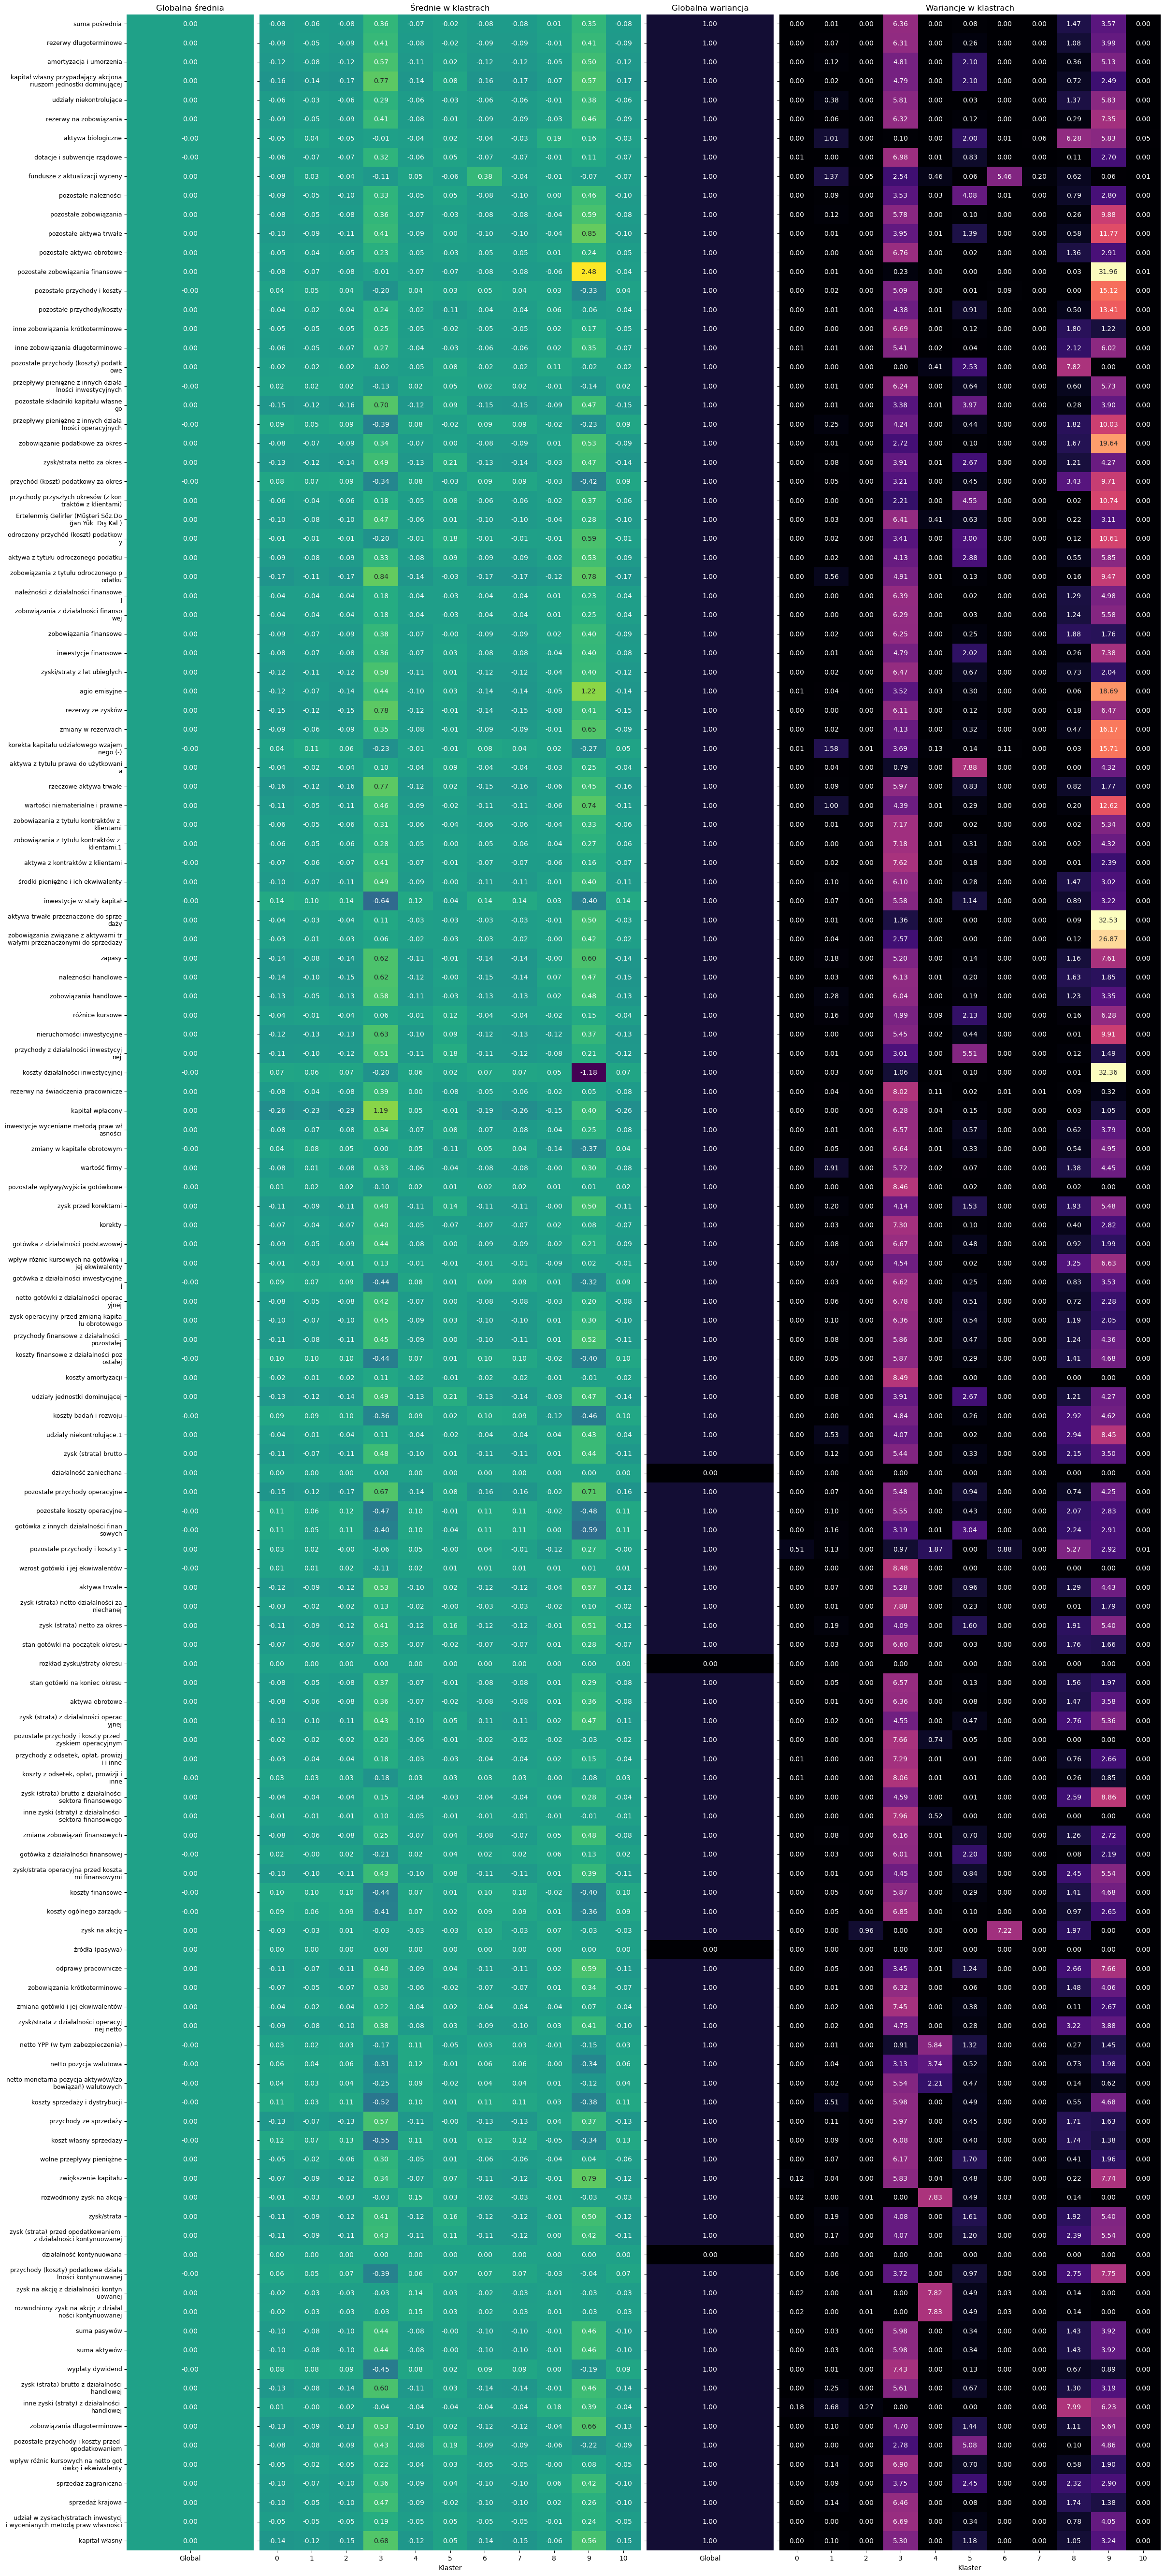

In [22]:
# 1.  DataFrame z oryginalnymi nazwami cech
df_scaled = pd.DataFrame(X_scaled[0], columns=df_filtered.columns, index=df_filtered.index)

# 2.  DataFrame dla indeksów
df_pca = pd.DataFrame(X_pca[0], index=df_scaled.index, columns=[f'PC{i+1}' for i in range(X_pca[0].shape[1])])

# 3. Etykiety klastrów jako Series
_series = pd.Series(labels_dict['KMedoids (manhattan)'], index=df_scaled.index, name="cluster")

# 4. Wywołanie analizy
_summary = cluster_summary(
    df_orig=df_scaled,       
    df_cluster=df_pca,       
    cluster_labels=_series
)


In [17]:
def prepare_X(df):
    return df.drop(columns=['Nazwa']) if 'Nazwa' in df.columns else df

# Przygotowanie danych
X_train = prepare_X(X_pca[0])

# t-SNE 3D na pełnym zbiorze (bez wykrywania i usuwania outlierów)
X_tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42).fit_transform(X_train)

# KMedoids z metryką Manhattan
kmedoids = KMedoids(n_clusters=11, metric='manhattan', init='heuristic', random_state=42)
labels = kmedoids.fit_predict(X_train)

# DataFrame do wizualizacji
df_3d = pd.DataFrame({
    'TSNE1': X_tsne_3d[:, 0],
    'TSNE2': X_tsne_3d[:, 1],
    'TSNE3': X_tsne_3d[:, 2],
    'Cluster': labels.astype(str)
})

# Mapa kolorów – zamiana koloru klastra '4' na czarny
color_map = {
    '0': '#1f77b4',  # niebieski
    '1': '#ff7f0e',  # pomarańczowy
    '2': '#2ca02c',  # zielony
    '3': '#d62728',  # czerwony
    '4': '#000000',  # czarny
    '5': '#9467bd',  # fioletowy
    '6': '#8c564b',  # brązowy
    '7': '#e377c2',  # różowy
    '8': '#7f7f7f',  # szary
    '9': '#bcbd22',  # oliwkowy
    '10': '#17becf'  # cyjan
}

# Interaktywny wykres
fig = px.scatter_3d(df_3d, x='TSNE1', y='TSNE2', z='TSNE3',
                    color='Cluster',
                    color_discrete_map=color_map,
                    title="KMedoids (Manhattan)",
                    opacity=0.75,
                    width=1000, height=800)
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(
    xaxis_title='TSNE1',
    yaxis_title='TSNE2',
    zaxis_title='TSNE3'
))
fig.show()

C:\Users\matja\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).

C:\Users\matja\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 10 is empty! self.labels_[self.medoid_indices_[10]] may not be labeled with its corresponding cluster (10).



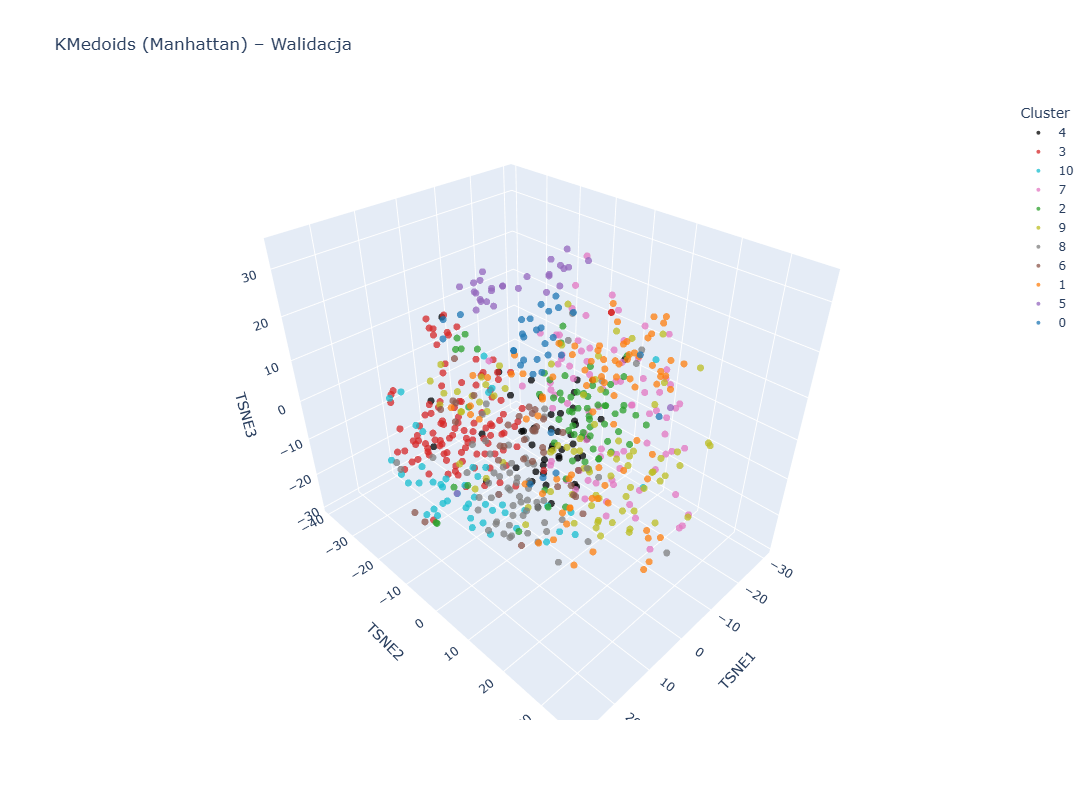

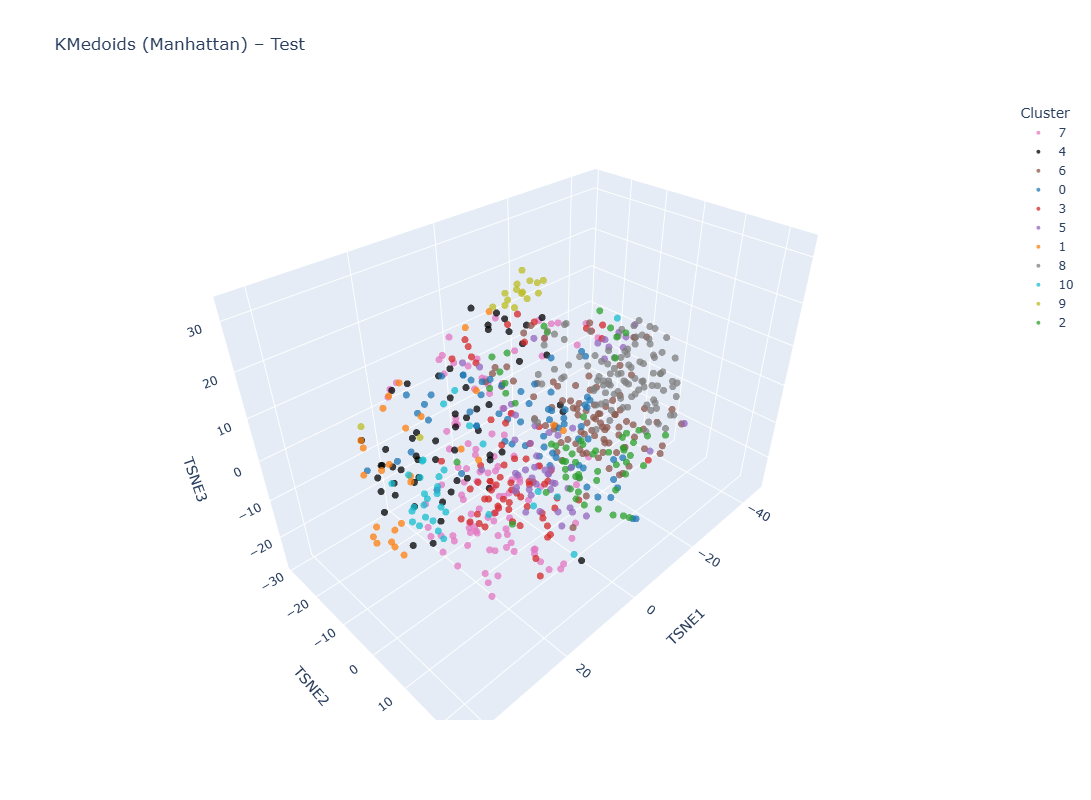

In [23]:
# Lista nazw dla etykiet wykresów
dataset_names = ['Walidacja', 'Test']

# Iteracja po zbiorach walidacyjnym i testowym
for i, name in zip([1, 2], dataset_names):
    # Przygotowanie danych
    X_curr = prepare_X(X_pca[i])

    # t-SNE 3D
    X_tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42).fit_transform(X_curr)

    # KMedoids z metryką Manhattan
    kmedoids = KMedoids(n_clusters=11, metric='manhattan', init='heuristic', random_state=42)
    labels = kmedoids.fit_predict(X_curr)

    # DataFrame do wizualizacji
    df_3d = pd.DataFrame({
        'TSNE1': X_tsne_3d[:, 0],
        'TSNE2': X_tsne_3d[:, 1],
        'TSNE3': X_tsne_3d[:, 2],
        'Cluster': labels.astype(str)
    })

    # Mapa kolorów – klaster 4 na czarno
    color_map = {
        '0': '#1f77b4',
        '1': '#ff7f0e',
        '2': '#2ca02c',
        '3': '#d62728',
        '4': '#000000',
        '5': '#9467bd',
        '6': '#8c564b',
        '7': '#e377c2',
        '8': '#7f7f7f',
        '9': '#bcbd22',
        '10': '#17becf'
    }

    # Interaktywny wykres
    fig = px.scatter_3d(df_3d, x='TSNE1', y='TSNE2', z='TSNE3',
                        color='Cluster',
                        color_discrete_map=color_map,
                        title=f"KMedoids (Manhattan) – {name}",
                        opacity=0.75,
                        width=1000, height=800)
    fig.update_traces(marker=dict(size=4))
    fig.update_layout(scene=dict(
        xaxis_title='TSNE1',
        yaxis_title='TSNE2',
        zaxis_title='TSNE3'
    ))
    fig.show()


==================== WALIDACJA – ANALIZA KLASTRÓW ====================



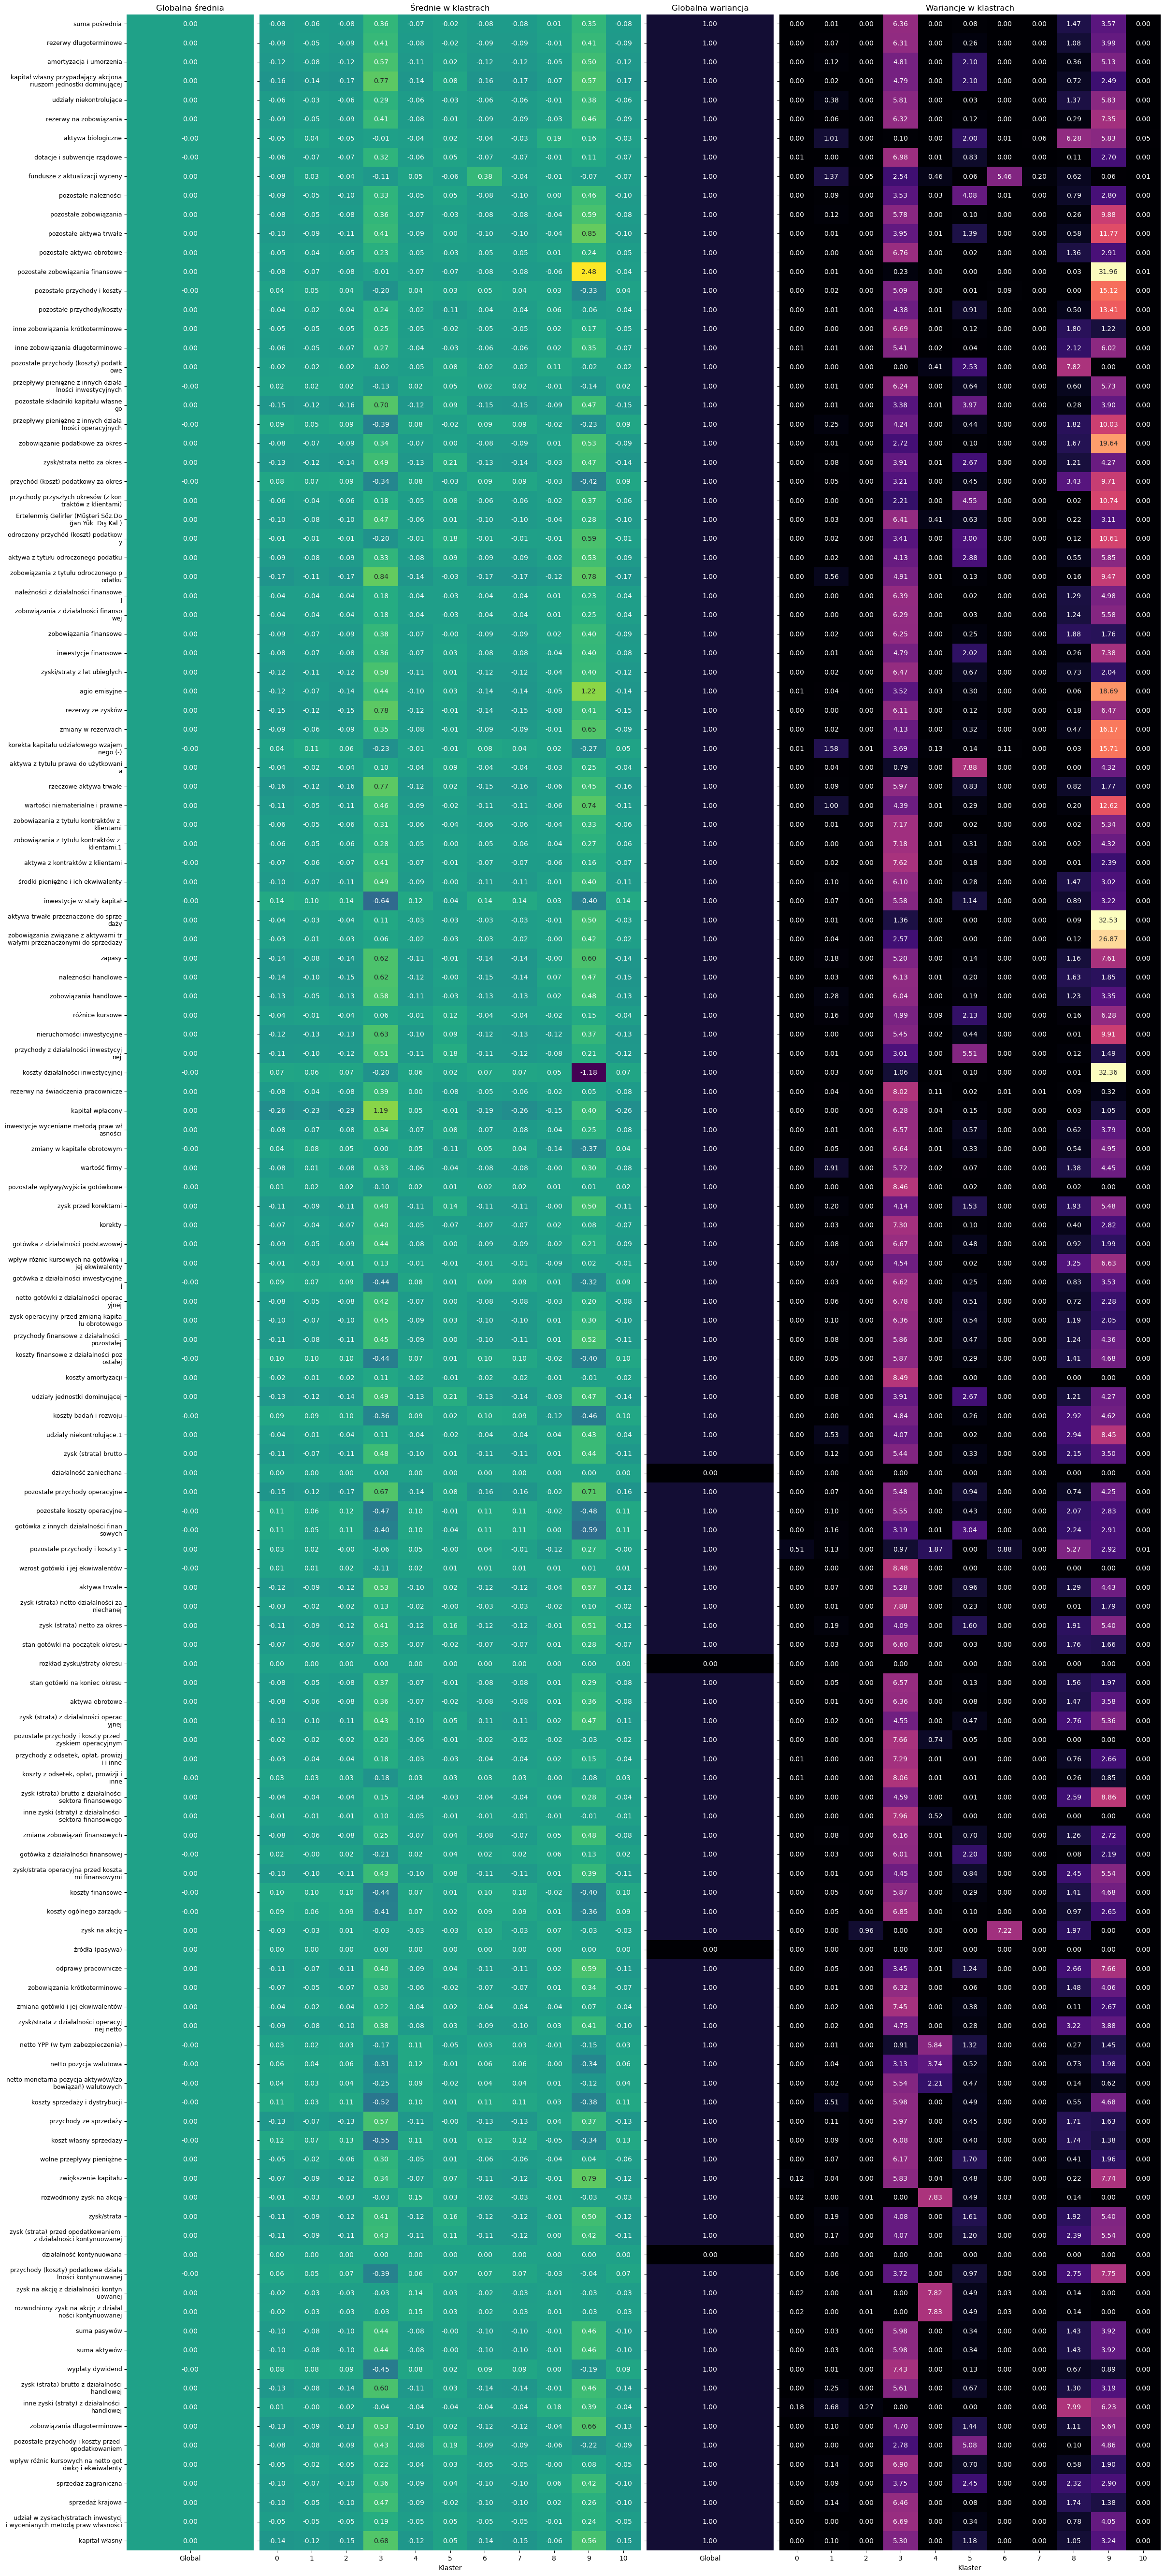


==================== TEST – ANALIZA KLASTRÓW ====================



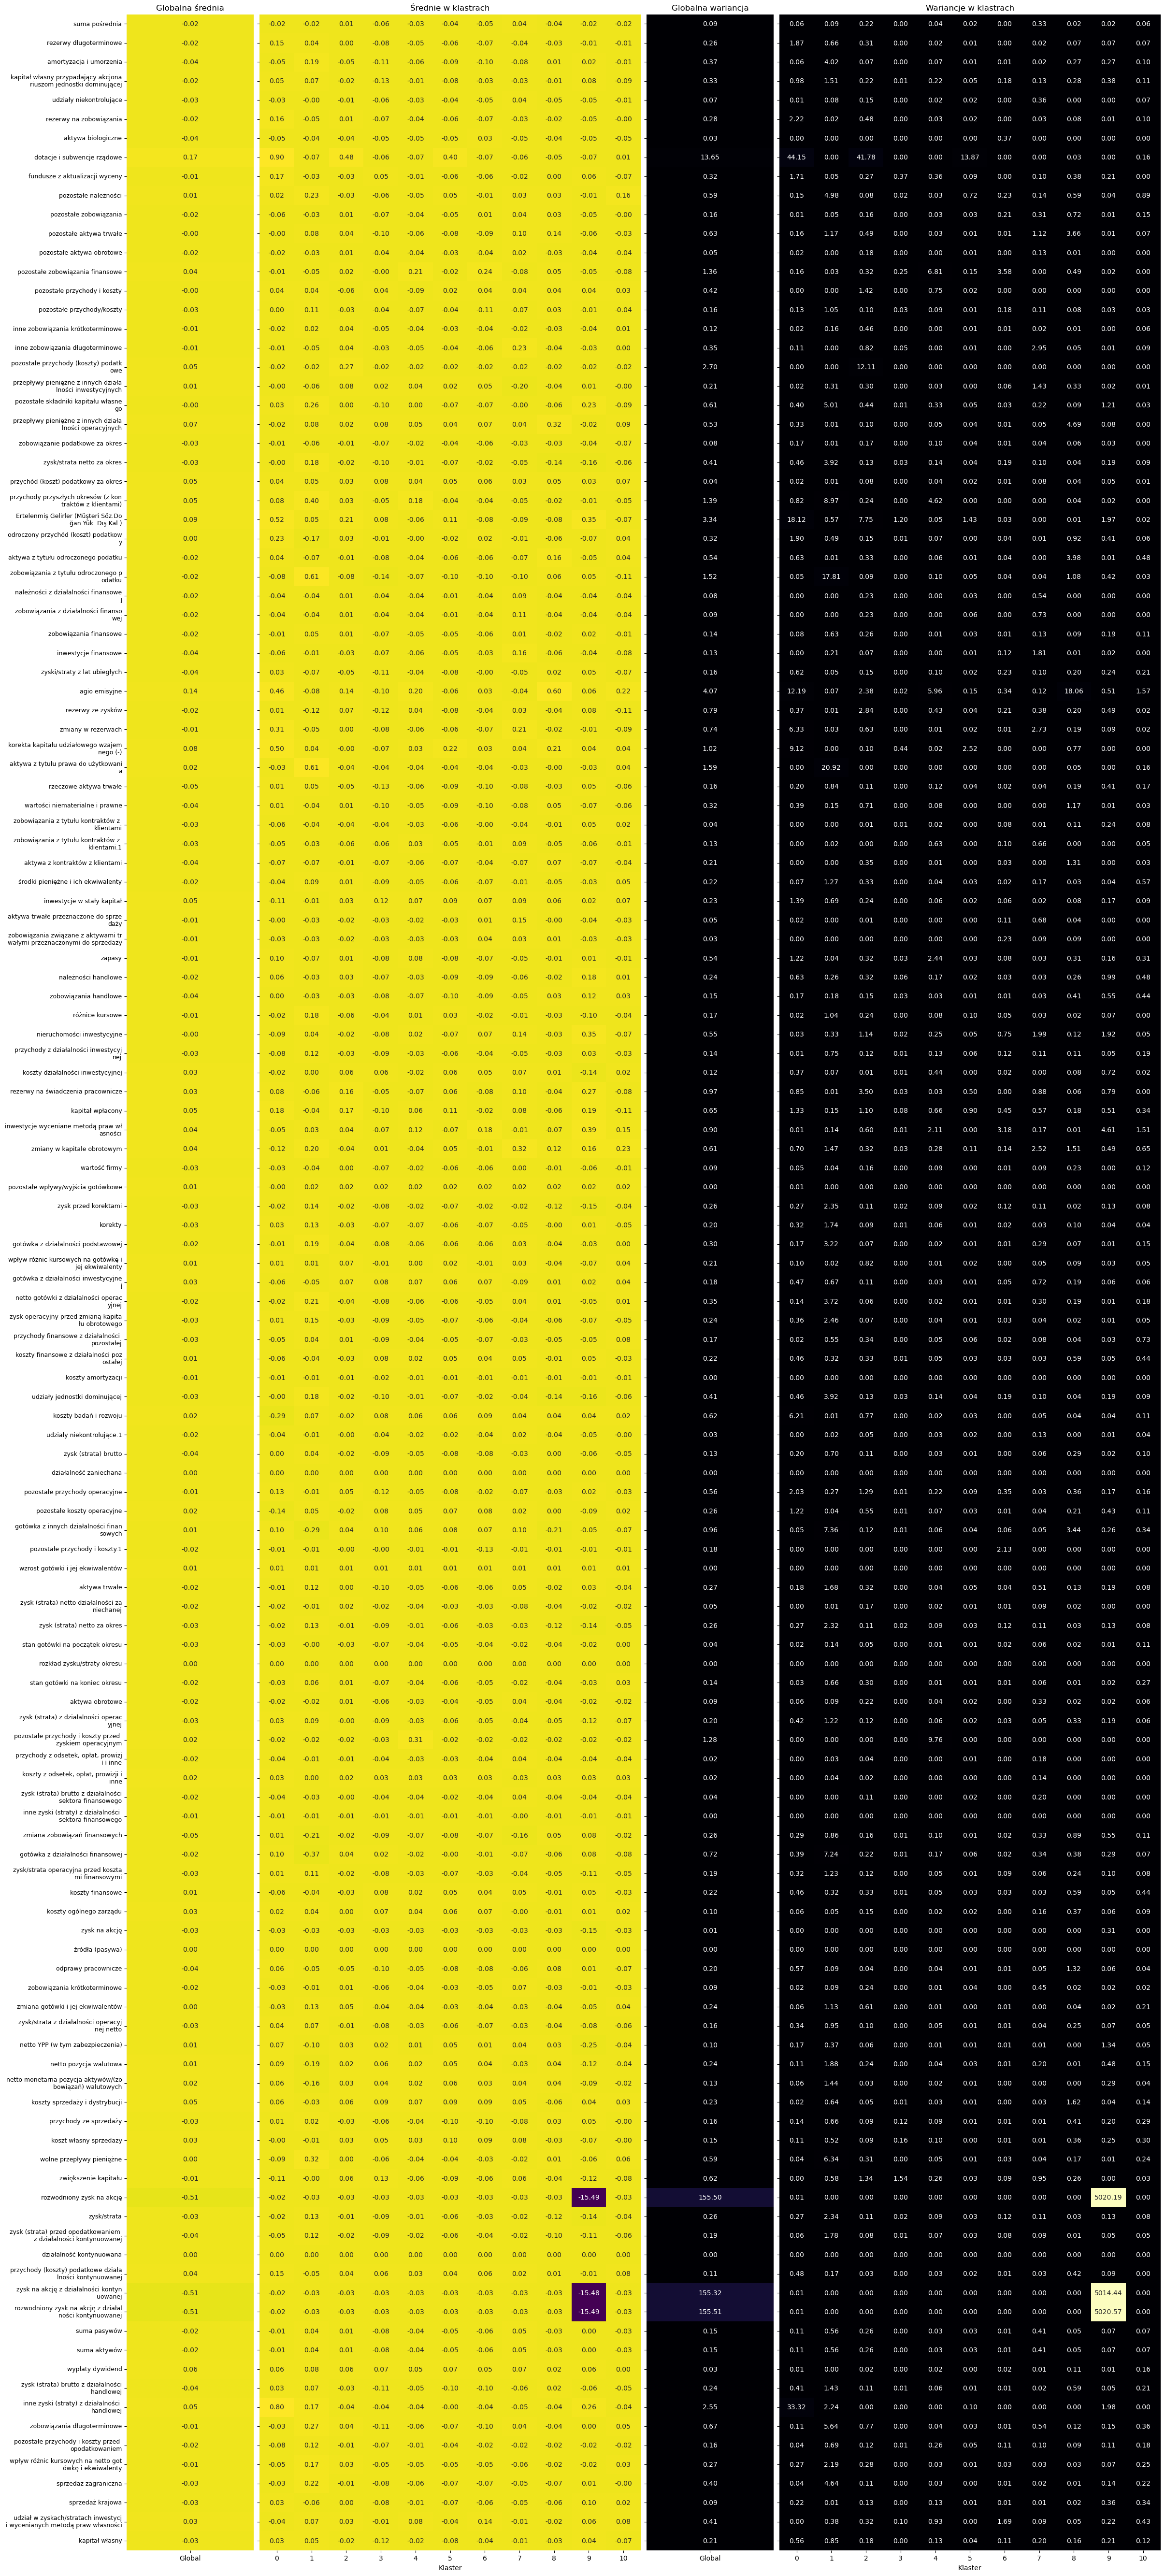

In [28]:
dataset_names = ['Walidacja', 'Test']

summaries = {}  # Do przechowywania wyników

for i, name in enumerate(dataset_names):
    # 1. DataFrame ze skalowanymi danymi i nazwami oryginalnych cech
    df_scaled = pd.DataFrame(X_scaled[i], columns=df_filtered.columns, index=df_filtered.index)

    # 2. DataFrame z PCA
    df_pca = pd.DataFrame(X_pca[i], columns=[f'PC{j+1}' for j in range(X_pca[i].shape[1])], index=df_scaled.index)

    # 3. Etykiety klastrów (dostosuj, jeśli masz osobne zbiory etykiet!)
    cluster_labels = pd.Series(labels_dict['KMedoids (manhattan)'], index=df_scaled.index, name="cluster")

    # 4. Tytuł tabeli
    print(f"\n{'='*20} {name.upper()} – ANALIZA KLASTRÓW {'='*20}\n")

    # 5. Wywołanie analizy
    summary_df = cluster_summary(
        df_orig=df_scaled,
        df_cluster=df_pca,
        cluster_labels=cluster_labels
    )

    summaries[name] = summary_df

In [29]:
_summary

global_mean  global_var  \
feature                                                                        
suma pośrednia                                      3.274994e-17    1.000184   
rezerwy długoterminowe                              3.078495e-17    1.000184   
amortyzacja i umorzenia                             2.161496e-17    1.000184   
kapitał własny przypadający akcjonariuszom jedn...  3.569744e-17    1.000184   
udziały niekontrolujące                             1.899497e-17    1.000184   
...                                                          ...         ...   
wpływ różnic kursowych na netto gotówkę i ekwiw...  2.914745e-17    1.000184   
sprzedaż zagraniczna                                2.472621e-17    1.000184   
sprzedaż krajowa                                    3.864493e-17    1.000184   
udział w zyskach/stratach inwestycji wycenianyc...  4.159243e-17    1.000184   
kapitał własny                                      2.161496e-17    1.000184   

                                                    mean_cluster_0  \
feature                                                              
suma pośrednia                                           -0.077015   
rezerwy długoterminowe                                   -0.088149   
amortyzacja i umorzenia                                  -0.120474   
kapitał własny przypadający akcjonariuszom jedn...       -0.164675   
udziały niekontrolujące                                  -0.063002   
...                                                            ...   
wpływ różnic kursowych na netto gotówkę i ekwiw...       -0.049578   
sprzedaż zagraniczna                                     -0.096457   
sprzedaż krajowa                                         -0.099424   
udział w zyskach/stratach inwestycji wycenianyc...       -0.049012   
kapitał własny                                           -0.144616   

                                                    var_cluster_0  \
feature                                                             
suma pośrednia                                           0.000045   
rezerwy długoterminowe                                   0.000031   
amortyzacja i umorzenia                                  0.000031   
kapitał własny przypadający akcjonariuszom jedn...       0.000112   
udziały niekontrolujące                                  0.000817   
...                                                           ...   
wpływ różnic kursowych na netto gotówkę i ekwiw...       0.000219   
sprzedaż zagraniczna                                     0.000024   
sprzedaż krajowa                                         0.000095   
udział w zyskach/stratach inwestycji wycenianyc...       0.000072   
kapitał własny                                           0.000249   

                                                    mean_cluster_1  \
feature                                                              
suma pośrednia                                           -0.060522   
rezerwy długoterminowe                                   -0.054812   
amortyzacja i umorzenia                                  -0.077230   
kapitał własny przypadający akcjonariuszom jedn...       -0.140482   
udziały niekontrolujące                                  -0.032131   
...                                                            ...   
wpływ różnic kursowych na netto gotówkę i ekwiw...       -0.016344   
sprzedaż zagraniczna                                     -0.069984   
sprzedaż krajowa                                         -0.048506   
udział w zyskach/stratach inwestycji wycenianyc...       -0.046371   
kapitał własny                                           -0.115963   

                                                    var_cluster_1  \
feature                                                             
suma pośrednia                                           0.013027   
rezerwy długoterminowe                                   0.066556   
amortyzacja i um

In [30]:
_summary.to_csv("summary_train.csv", encoding="utf-8-sig")

# Klasyfikacja klastrów spółek – Giełda Turecka

## Klaster 0 – **Kapitałochłonne spółki operacyjne**
Spółki z wysokimi kosztami operacyjnymi i inwestycyjnymi, ale relatywnie niskim kapitałem własnym. Charakteryzują się intensywną działalnością bieżącą przy niskiej bazie kapitałowej.

---

## Klaster 1 – **Spółki innowacyjne z wysokimi kosztami finansowymi**
Firmy inwestujące w badania i rozwój, jednocześnie ponoszące duże koszty finansowe. Cechuje je także relatywnie niski poziom kapitału podstawowego.

---

## Klaster 2 – **Kapitałochłonne spółki przemysłowe**
Przedsiębiorstwa operujące z dużymi nakładami na produkcję i inwestycje, lecz o słabszej strukturze kapitałowej. Typowe dla sektorów przemysłowych o niskiej marży.

---

## Klaster 3 – **Spółki o silnej strukturze bilansu**
Stabilne firmy z dużym kapitałem własnym i aktywami trwałymi. Niskie koszty operacyjne i konserwatywna polityka finansowa czynią je defensywnymi inwestycjami.

---

## Klaster 4 – **Eksporterzy o wysokiej rentowności**
Spółki o wysokim zysku na akcję i pozycji walutowej, co sugeruje znaczną ekspozycję na eksport. Mogą być liderami branż o wysokiej marży.

---

## Klaster 5 – **Spółki zyskowne i dobrze zarządzające podatkami**
Charakteryzują się wysokimi zyskami netto i przychodami inwestycyjnymi. Efektywne zarządzanie podatkami i dominująca pozycja właścicielska.

---

## Klaster 6 – **Spółki przeszacowujące majątek**
Firmy z wysokimi wartościami funduszy z aktualizacji wyceny. Może to oznaczać przeszacowanie aktywów lub operacje związane z wyceną majątku trwałego.

---

## Klaster 7 – **Spółki wielkoskalowe z intensywną działalnością**
Duże organizacje z wysokimi kosztami sprzedaży i dystrybucji, które mogą działać na szeroką skalę przy ograniczonym kapitale własnym.

---

## Klaster 8 – **Spółki handlowo-rolnicze**
Firmy z aktywami biologicznymi i przychodami handlowymi. Silna ekspozycja na sektor rolniczy, handel towarowy lub przetwórstwo.

---

## Klaster 9 – **Spółki ekspansywne finansowane długiem**
Podmioty o wysokim zadłużeniu finansowym i emisjach kapitału. Intensywnie rozwijają działalność przy dużym wykorzystaniu finansowania zewnętrznego.

---

## Klaster 10 – **Spółki intensywnie operujące z niskim kapitałem**
Firmy z bardzo dużą aktywnością operacyjną i inwestycyjną, ale relatywnie niskim kapitałem własnym. Często występują w sektorach niskomarżowych.